<a href="https://colab.research.google.com/github/ifte110/tensorflow-deep-learning-0toM-Self-Practice/blob/main/04_transfer_learning_feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import zipfile

In [1]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip


--2023-08-16 18:39:06--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.148.128, 142.251.172.128, 209.85.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.148.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   286MB/s    in 0.6s    

2023-08-16 18:39:07 (286 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [5]:
import os
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"


train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [28]:
import datetime
import tensorflow as tf

def creat_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().\
  strftime("%Y%m%d-%H%M%S")
  tensorboard_callback =tf.keras.callbacks.TensorBoard(log_dir)
  print(f"saving TB log file to: {log_dir}")
  return tensorboard_callback


In [8]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [21]:
from keras.layers.attention.multi_head_attention import activation
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

def creat_model(model_url, num_classes=10):
  feature_extract_layer = hub.KerasLayer(model_url, trainable = False,
                                         name= "feature_extraction",
                                         input_shape=IMAGE_SHAPE+(3,))

  model = tf.keras.Sequential([
      feature_extract_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

In [10]:
resnet_model = creat_model(resnet_url,num_classes=train_data_10_percent.\
                           num_classes)

In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction (KerasLa  (None, 2048)             23564800  
 yer)                                                            
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [14]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [15]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction (KerasLa  (None, 2048)             23564800  
 yer)                                                            
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [16]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data= test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[creat_tensorboard_callback(dir_name="tensorflow_hub",
                                                                       experiment_name="resnet_v2_50"
                                                                       )])


saving TB log file to: tensorflow_hub/resnet_v2_50/20230816-184105
Epoch 1/5
24/24 [==============================] - 25s 537ms/step - loss: 1.9371 - accuracy: 0.3467 - val_loss: 1.1939 - val_accuracy: 0.6184
Epoch 2/5
24/24 [==============================] - 13s 544ms/step - loss: 0.9225 - accuracy: 0.7213 - val_loss: 0.8571 - val_accuracy: 0.7208
Epoch 3/5
24/24 [==============================] - 10s 442ms/step - loss: 0.6453 - accuracy: 0.7907 - val_loss: 0.7781 - val_accuracy: 0.7436
Epoch 4/5
24/24 [==============================] - 10s 440ms/step - loss: 0.4771 - accuracy: 0.8773 - val_loss: 0.7006 - val_accuracy: 0.7684
Epoch 5/5
24/24 [==============================] - 10s 448ms/step - loss: 0.3890 - accuracy: 0.9080 - val_loss: 0.6753 - val_accuracy: 0.7808


In [17]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

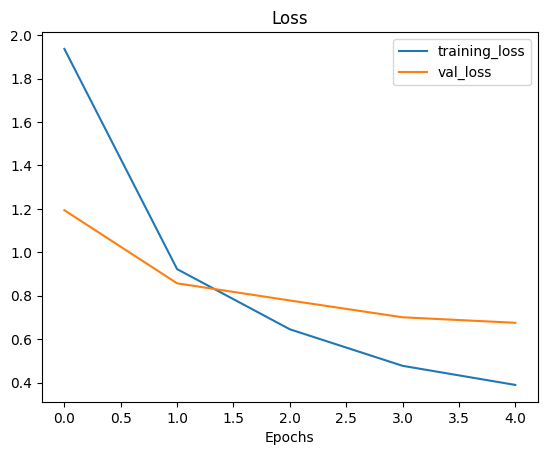

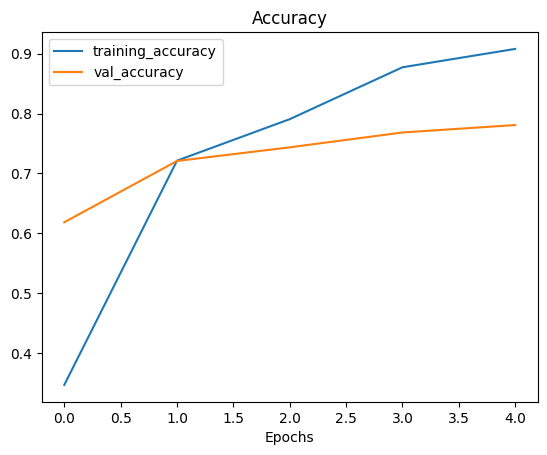

In [18]:
plot_loss_curves(resnet_history)

In [22]:
efficientnet_model = creat_model(model_url=efficientnet_url,
                                num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[creat_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                    experiment_name="efficientnetB0")])


saving TB log file to: tensorflow_hub/efficientnetB0/20230816-190924
Epoch 1/5
24/24 [==============================] - 23s 516ms/step - loss: 1.8253 - accuracy: 0.4360 - val_loss: 1.2668 - val_accuracy: 0.7428
Epoch 2/5
24/24 [==============================] - 12s 535ms/step - loss: 1.0408 - accuracy: 0.7933 - val_loss: 0.8480 - val_accuracy: 0.8188
Epoch 3/5
24/24 [==============================] - 13s 547ms/step - loss: 0.7404 - accuracy: 0.8387 - val_loss: 0.6818 - val_accuracy: 0.8496
Epoch 4/5
24/24 [==============================] - 10s 415ms/step - loss: 0.5960 - accuracy: 0.8720 - val_loss: 0.6008 - val_accuracy: 0.8600
Epoch 5/5
24/24 [==============================] - 10s 419ms/step - loss: 0.5049 - accuracy: 0.9000 - val_loss: 0.5478 - val_accuracy: 0.8652


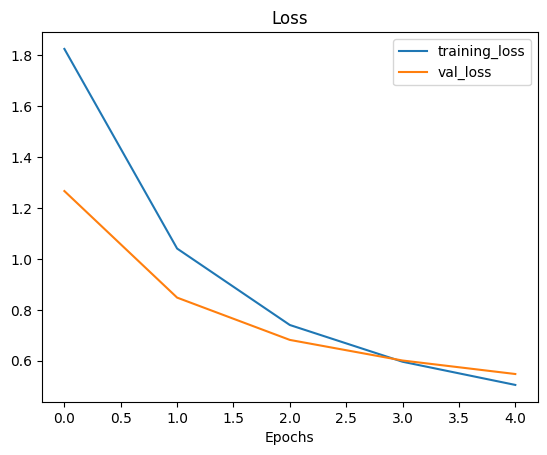

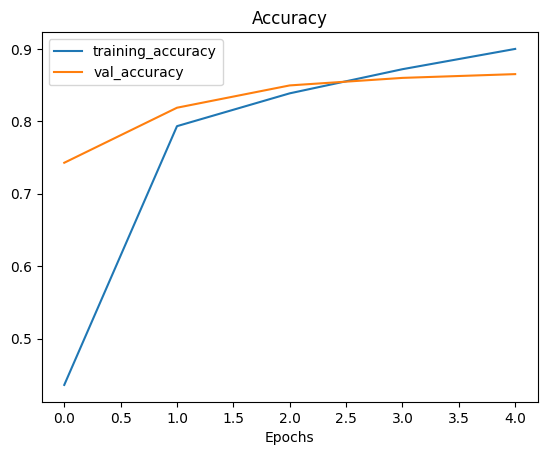

In [23]:
plot_loss_curves(efficientnet_history)

In [24]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction (KerasLa  (None, 1280)             4049564   
 yer)                                                            
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


TensorBoard at https://tensorboard.dev/experiment/ZvMA4JXqT3mwS7Idi3gwfQ/

In [ ]:
# !tensorboard dev upload --logdir ./tensorflow_hub/ \
#   --name "EfficientNetB0 vs. ResNet50V2" \
#   --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
#   --one_shot

In [31]:
!tensorboard dev list

2023-08-16 20:14:46.694747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/ZvMA4JXqT3mwS7Idi3gwfQ/
	Name                 EffNetB0 vs ResNet50v2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   ZvMA4JXqT3mwS7Idi3gwfQ
	Created              2023-08-16 20:03:19 (11 minutes ago)
	Updated              2023-08-16 20:03:21 (11 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5919414
Total: 1 experiment(s)


In [ ]:
# !tensorboard dev delete --experiment_id YYXXXXXZZZZZZS